# Creating The Statistic

The goal of the statistic should be to perform the same or even better than the original model did. However, I decided to make a few extra changes:
* Replaced the "All Heroes" selection in favor of including heroes, as stats vary by hero more than individual performance
* As referenced above, stats are converted to stats per 10 minutes played to allow for a more even balance

In [571]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stats = pd.read_csv('new csv files/OWL_stats.csv')
sep_imp = pd.read_csv('new csv files/sep_imp.csv')

In [572]:
stat_df = stats.drop(['match_id', 'Final Blows', 'Damage - Quick Melee', 'Time Holding Ultimate',
                           'Objective Kills', 'All Damage Done', 'Average Time Alive',
                            'Ultimates Earned - Fractional', 'team', 'map_name', 'map_type'], axis=1)
stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']] = stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']].fillna(value=0)
stat_df['Damage Taken'].fillna(value=stat_df['Damage Taken'].mean(), inplace = True)

## First Attempt

For now, the goal is to go basic and utilize the feature importance values in combination with the actual stats:
* Stats were converted to stats per 10 for better comparison
* I scaled the feature importances from 0 to 1 and then multiplied those values with each column to produce a new statistic for each player.

In [467]:
stat_df['Time Played'] = stat_df['Time Played'].multiply(1.0/60.0)

for i in stat_df.columns[2:12]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])
    
for i in stat_df.columns[14:15]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])

stat_df.drop('Time Played', axis=1, inplace=True)

In [468]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
spec = sep_imp['Importance'].to_numpy()
scale_imp = scaler.fit_transform(spec.reshape(-1, 1))
scale_imp[0] *= -1
scale_imp[5] *= -1

x = stat_df.select_dtypes(float).columns
temp = np.dot(stat_df[x], scale_imp)
stat_df['Stat'] = temp

Some players did not have enough play time to register stats, and as such will not have a statistic for their play

In [106]:
stat_df = stat_df[stat_df['Stat'].notna()]
stat_df

,player,hero,Assists,Barrier Damage Done,Damage Taken,Deaths,Eliminations,Hero Damage Done,Objective Time,Shots Fired,Time Alive,Time Building Ultimate,Time Elapsed per Ultimate Earned,Ultimates Used,Weapon Accuracy,match_winner,map_winner,Stat
15,Envy,D.Va,13.308692,2660.975112,9559.079911,4.158966,24.953798,9185.513733,63.384313,12501.852903,562.046058,496.541505,47.278730,14.140486,0.331936,True,True,4513.638994
17,Fate,Winston,14.064711,1050.306562,11850.998731,6.618688,21.510735,7897.068292,72.455603,0.000000,552.317915,517.584697,90.769549,4.136680,0.000000,True,True,3156.989438
20,SoOn,Tracer,9.732420,2140.729071,3904.605691,6.488280,18.383460,7695.160535,72.820133,4952.720491,539.937385,446.989526,64.733371,5.406900,0.309825,True,True,2437.085096
21,SoOn,Widowmaker,10.565071,1247.862114,2996.534424,7.043381,28.173524,11826.973571,5.275492,239.474952,588.449843,421.937270,61.240563,3.521690,0.397059,True,True,874.623892
22,silkthread,Genji,12.265837,1799.976074,3549.628618,3.066459,24.531673,6608.355630,14.467555,870.874397,588.192877,443.784113,112.003123,3.066459,0.207746,True,True,1935.976647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105878,Assassin,Mei,2.691767,4147.393806,5806.810431,12.112951,8.075301,5585.365558,35.527288,265.139048,486.760313,539.957705,113.193384,4.037650,0.257353,False,False,4562.951872
105879,BEBE,Baptiste,2.662707,5133.673020,3693.026683,9.319476,5.325415,3899.101848,14.668856,901.326481,515.043528,441.082831,80.592548,3.994061,0.322222,False,False,5064.298041
105880,Closer,Lúcio,5.325415,2409.750266,4337.809736,9.319476,5.325415,3515.812307,41.974922,760.202984,523.421738,561.498455,146.852448,2.662707,0.291566,False,False,2903.561326
105882,Decay,Symmetra,10.924143,5385.758867,4841.759767,9.363551,10.924143,4085.705513,60.869328,107.680840,503.027160,522.195910,142.435825,1.560592,0.290323,False,False,5500.855570


### Comparison

Based on the accuracy score, it is clear the stat is not much better than randomly selecting a win or loss, and this is evidenced by the confusion matrix which shows an even distribution within all possible outcomes.

In [107]:
y_match = stat_df['match_winner'] # Predicts match wins
y_map = stat_df['map_winner'] # Predicts map wins

X = stat_df[['Stat']]

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_match, test_size=0.2, random_state=42)

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, rf_clf.predict(X_test)))

Train accuracy score: 0.9991486760821636
Test accuracy score: 0.505457085479787


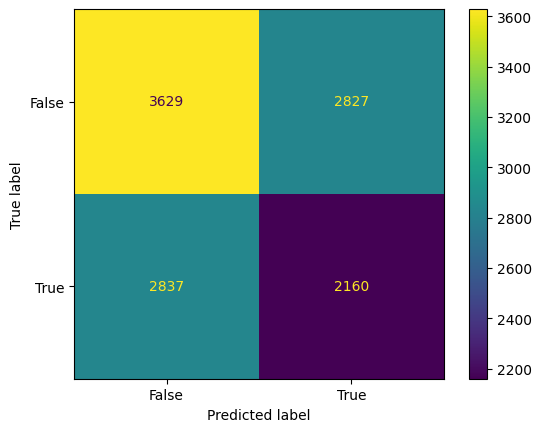

In [110]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### Conclusion

The main issue from looking at individuals stats in comparison to the combined stat is that certain stats are easier to accumulate (hero damage, shots fired) than other stats (eliminations, deaths). While easier to accumulate stats appear to have less importance, when simply scaled and multiplied, their importance becomes much more significant, so all of the stats may need to be scaled to give a more accurate depiction for a stat.

## Second Attempt

This time around, the stat will be hero-dependent, which should provide a more even playing field and thus create better predictions:
* Entries were removed when time played on a hero was less than 3 minutes
* I incorrectly created the stat initially, so the columns are correctly aligned for the proper dot product to be calculated this time
* Feature importance values were tuned to be better predictors for map wins
* Heroes were added in to the model for predicting value

In [573]:
stat_df = stats.drop(['Final Blows',
                           'Objective Kills', 'All Damage Done',
                            'Ultimates Earned - Fractional'], axis=1)
stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']] = stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']].fillna(value=0)
#stat_df['Damage Taken'].fillna(value=stat_df['Damage Taken'].mean(), inplace = True)

In [574]:
from sklearn.preprocessing import MinMaxScaler

stat_df['Time Played'] = stat_df['Time Played'].multiply(1.0/60.0)

for i in stat_df.columns[6:16]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])
    #scaler = MinMaxScaler(feature_range=(0,100))
    #stat_df[i] = scaler.fit_transform(stat_df[[i]].to_numpy())
    
for i in stat_df.columns[18:19]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])
    #scaler = MinMaxScaler(feature_range=(0,100))
    #stat_df[i] = scaler.fit_transform(stat_df[[i]].to_numpy())

stat_df = stat_df[stat_df['Time Played'] > 3] 
stat_df.drop('Time Played', axis=1, inplace=True)

In [575]:
from sklearn.preprocessing import MinMaxScaler
from pandas import Index

scaler = MinMaxScaler(feature_range=(0,100))
features = sep_imp['Feature']
temp = sep_imp.drop('Feature', axis=1)
scale_imp = scaler.fit_transform(temp.to_numpy())
scale_imp[Index(sep_imp['Feature']).get_loc('Eliminations')] *= 30
scale_imp[Index(sep_imp['Feature']).get_loc('Deaths')] *= -30
scale_imp[Index(sep_imp['Feature']).get_loc('Damage Taken')] *= -0.1
scale_imp[Index(sep_imp['Feature']).get_loc('Time Elapsed per Ultimate Earned')] *= -0.1
scale_imp[Index(sep_imp['Feature']).get_loc('Barrier Damage Done')] *= 0.1
scale_imp[Index(sep_imp['Feature']).get_loc('Objective Time')] *= 0.1
scale_imp[Index(sep_imp['Feature']).get_loc('Hero Damage Done')] *= 0.1

first_set = stat_df[stat_df.columns[0:6]]
match = stat_df['match_winner']
maps = stat_df['map_winner']

stat_df = stat_df.reindex(columns=features)
x = stat_df.select_dtypes(float).columns
dot = np.dot(stat_df[x], scale_imp)
stat_df['Stat'] = dot
stat_df = stat_df[stat_df['Stat'].notna()]

temp = pd.DataFrame(stat_df) # To allow for name resusage
stat_df = first_set.merge(temp, how='inner', left_index=True, right_index=True)
stat_df['match_winner'] = match
stat_df['map_winner'] = maps
stat_df.drop('Time Holding Ultimate', axis=1, inplace=True)

In [576]:
heroes = stat_df['hero'].unique()
averages = {}

for hero in heroes:
    hero_df = stat_df[stat_df['hero'] == hero]
    averages[hero] = hero_df['Stat'].mean()

In [577]:
from sklearn.preprocessing import MinMaxScaler
def func(stat, hero):
    return stat * 1.0/averages[hero]

stat_df['Stat'] = stat_df.apply((lambda x: func(x['Stat'], x['hero'])), axis=1)
dfs = {}

for hero in heroes:
    cur = stat_df[stat_df['hero'] == hero]
    scaler = MinMaxScaler(feature_range=(30,100))
    cur['Stat'] = scaler.fit_transform(cur[['Stat']].to_numpy())
    dfs[hero] = cur
    
stat_df = pd.concat(dfs.values())

In [578]:
stat_df[stat_df['hero'] == 'Winston'].sort_values(by='Stat', ascending=False)

,match_id,map_name,map_type,team,player,hero,Eliminations,Deaths,Assists,Objective Time,Time Building Ultimate,Damage Taken,Hero Damage Done,Barrier Damage Done,Shots Fired,Weapon Accuracy,Ultimates Used,Time Elapsed per Ultimate Earned,Stat,match_winner,map_winner
33452,21256,Rialto,PAYLOAD,Philadelphia Fusion,SADO,Winston,46.967357,2.935460,29.354598,22.520848,117.094003,10290.834029,7738.877113,4257.172774,0.0,0.0,1.0,331.664226,100.000000,False,True
61730,31037,Havana,PAYLOAD,Houston Outlaws,Muma,Winston,44.651768,1.717376,34.347514,92.422294,271.466008,12163.021747,10223.863204,2996.217793,0.0,0.0,3.0,116.708447,98.853142,True,True
79337,34823,Nepal,CONTROL,Boston Uprising,Fusions,Winston,43.881698,2.089605,35.523280,70.066537,219.010006,17082.576198,12663.775856,4722.850726,0.0,0.0,3.0,131.220820,96.419154,False,True
103734,37420,King's Row,HYBRID,Dallas Fuel,FEARLESS,Winston,42.555086,3.273468,28.370057,247.455650,379.717011,7715.404077,7982.434181,2373.209147,0.0,0.0,3.0,102.998511,96.161705,True,True
39043,21310,Numbani,HYBRID,Philadelphia Fusion,SADO,Winston,40.775024,2.398531,26.383839,41.873553,208.311006,9901.920076,13613.135880,5462.445552,0.0,0.0,3.0,162.975978,94.753060,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105602,37445,Route 66,PAYLOAD,San Francisco Shock,super,Winston,4.971225,14.913676,4.971225,43.540478,167.526005,15999.132871,5006.090796,181.002327,0.0,0.0,1.0,323.352470,32.639887,True,False
100449,37380,Temple of Anubis,ASSAULT,Dallas Fuel,FEARLESS,Winston,2.061702,12.370210,2.061702,15.471010,281.705008,14452.698962,3294.279045,967.817935,0.0,0.0,1.0,345.641356,32.253003,True,False
16839,10472,Horizon Lunar Colony,ASSAULT,Philadelphia Fusion,SADO,Winston,2.163008,12.978050,2.163008,33.734278,261.415008,14038.109833,1825.308934,1855.986243,0.0,0.0,1.0,399.103944,31.592017,False,False
13064,10373,Junkertown,PAYLOAD,San Francisco Shock,Nomy,Winston,4.914380,17.200331,4.914380,21.552014,228.401007,14114.406672,5620.274058,1141.835624,0.0,0.0,1.0,272.681532,31.136835,False,False


### Comparison

Compared to the previous attempt, there appears to be a 10% gain in the accuracy of the model compared to the first attempt

In [579]:
stat_df = pd.get_dummies(stat_df, prefix=['hero'], columns=['hero'])
cols = stat_df.columns.to_list()[20:]
cols.append('Stat')

Train accuracy score: 0.9997674271095418
Test accuracy score: 0.6513319238900634


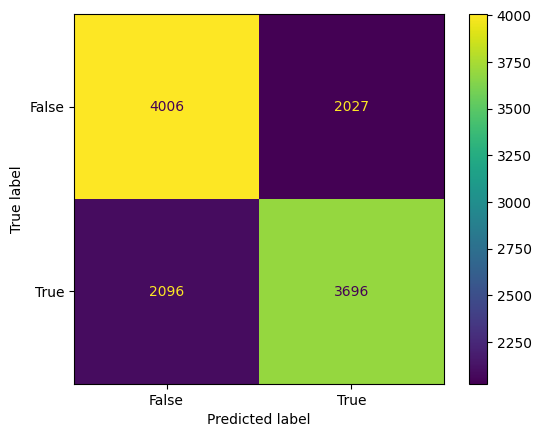

In [583]:
y_match = stat_df['match_winner'] # Predicts match wins
y_map = stat_df['map_winner'] # Predicts map wins

X = stat_df[cols]



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_map, test_size=0.2, random_state=46)




from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, rf_clf.predict(X_test)))



from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### Saving for use in part 3

In [455]:
stat_df.to_csv('new csv files/stat_df.csv', index=False)